In [1]:
import os
import sys
import argparse
import cv2
import random
import colorsys
import requests
from io import BytesIO

import skimage.io
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np
from PIL import Image

from scipy.linalg import eigh, inv
from scipy.sparse import identity
from scipy import ndimage
from sklearn.cluster import KMeans

import utils
sys.path.append("..") # append parent path
import models.vision_transformer as vits

import glob
import json

root = 'vis_examples/' # 이미지 저장 위치
coco_annotations_file = '/home/shhan/oicr/data/coco/annotations/instances_train2017.json' # annotation path
coco_images_dir = "/home/shhan/oicr/data/coco/images/train2017" # data path

/home/shhan/.local/lib/python3.8/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (5.1.0)/charset_normalizer (2.1.1) doesn't match a supported version!
  warnings.warn(


In [4]:
from collections import defaultdict
import json
import numpy as np
class COCOParser:
    def __init__(self, anns_file, imgs_dir):
        with open(anns_file, 'r') as f:
            coco = json.load(f)
            
        self.annIm_dict = defaultdict(list)        
        self.cat_dict = {} 
        self.annId_dict = {}
        self.im_dict = {}
        self.licenses_dict = {}
        for ann in coco['annotations']:           
            self.annIm_dict[ann['image_id']].append(ann) 
            self.annId_dict[ann['id']]=ann
        for img in coco['images']:
            self.im_dict[img['id']] = img
        for cat in coco['categories']:
            self.cat_dict[cat['id']] = cat
        for license in coco['licenses']:
            self.licenses_dict[license['id']] = license
    def get_imgIds(self):
        return list(self.im_dict.keys())
    def get_annIds(self, im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        return [ann['id'] for im_id in im_ids for ann in self.annIm_dict[im_id]]
    def load_anns(self, ann_ids):
        im_ids=ann_ids if isinstance(ann_ids, list) else [ann_ids]
        return [self.annId_dict[ann_id] for ann_id in ann_ids]        
    def load_cats(self, class_ids):
        class_ids=class_ids if isinstance(class_ids, list) else [class_ids]
        return [self.cat_dict[class_id] for class_id in class_ids]
    def get_imgLicenses(self,im_ids):
        im_ids=im_ids if isinstance(im_ids, list) else [im_ids]
        lic_ids = [self.im_dict[im_id]["license"] for im_id in im_ids]
        return [self.licenses_dict[lic_id] for lic_id in lic_ids]

In [5]:
coco= COCOParser(coco_annotations_file, coco_images_dir)

In [6]:
coco.im_dict

{391895: {'license': 3,
  'file_name': '000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895},
 522418: {'license': 4,
  'file_name': '000000522418.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000522418.jpg',
  'height': 480,
  'width': 640,
  'date_captured': '2013-11-14 11:38:44',
  'flickr_url': 'http://farm1.staticflickr.com/1/127244861_ab0c0381e7_z.jpg',
  'id': 522418},
 184613: {'license': 3,
  'file_name': '000000184613.jpg',
  'coco_url': 'http://images.cocodataset.org/train2017/000000184613.jpg',
  'height': 336,
  'width': 500,
  'date_captured': '2013-11-14 12:36:29',
  'flickr_url': 'http://farm3.staticflickr.com/2169/2118578392_1193aa04a0_z.jpg',
  'id': 184613},
 318219: {'license': 3,
  'file_name': '000000318219.jpg',
  'coco_url': 'http://im

In [7]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# define a list of colors for drawing bounding boxes

def get_gt(img_path, orig_img, pad):
    if img_path.split('/')[6][-4:] == '2017':
        img_id = int(img_path.split('/')[-1].split('.')[0])
    else:
        img_id = int(img_path.split('/')[-1].split('_')[-1].split('.')[0])
    print(img_id)
    color_list = ["pink", "red", "teal", "blue", "orange", "yellow", "black", "magenta","green","aqua"]*10
    selected_img_ids = [img_id]
    # print(selected_img_ids)
    ann_ids = coco.get_annIds(selected_img_ids)
    im_licenses = coco.get_imgLicenses(selected_img_ids)
    fig = plt.plot(figsize=(15,10))
    # ax = ax.ravel()
    im = selected_img_ids[0]
    image = orig_img#Image.open(img_path)
    #image = Image.open(f"{coco_images_dir}/{coco_image_name}{str(im).zfill(12)}.jpg\'")
    ann_ids = coco.get_annIds(im)
    annotations = coco.load_anns(ann_ids)
    i = 0
    for ann in annotations[:-2]:
        bbox = ann['bbox']
        x, y, w, h = [int(b) for b in bbox]; x+=pad[0]; y+=pad[1]
        class_id = ann["category_id"]
        class_name = coco.load_cats(class_id)[0]["name"]
        license = coco.get_imgLicenses(im)[0]["name"]
        color_ = color_list[class_id]
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color_, facecolor='none')
        t_box=plt.text(x, y, class_name,  color='red', fontsize=10)
        t_box.set_bbox(dict(boxstyle='square, pad=0',facecolor='white', alpha=0.6, edgecolor='blue'))
        plt.gca().add_patch(rect)
        # print(rect)
    plt.axis('off')
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

In [8]:
def apply_mask(image, mask, color, alpha=0.5):
    for c in range(3):
        image[:, :, c] = image[:, :, c] * (1 - alpha * mask) + alpha * mask * color[c] * 255
    return image

def random_colors(N, bright=True):
    """
    Generate random colors.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def display_instances(image, mask, fname="test", figsize=(5, 5), blur=False, contour=True, alpha=0.5):
    fig = plt.figure(figsize=figsize, frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax = plt.gca()

    N = 1
    mask = mask[None, :, :]
    # Generate random colors
    colors = random_colors(N)

    # Show area outside image boundaries.
    height, width = image.shape[:2]
    margin = 0
    ax.set_ylim(height + margin, -margin)
    ax.set_xlim(-margin, width + margin)
    ax.axis('off')
    masked_image = image.astype(np.uint32).copy()
    for i in range(N):
        color = colors[i]
        _mask = mask[i]
        if blur:
            _mask = cv2.blur(_mask,(10,10))
        # Mask
        masked_image = apply_mask(masked_image, _mask, color, alpha)
        # Mask Polygon
        # Pad to ensure proper polygons for masks that touch image edges.
        if contour:
            padded_mask = np.zeros((_mask.shape[0] + 2, _mask.shape[1] + 2))
            padded_mask[1:-1, 1:-1] = _mask
            contours = find_contours(padded_mask, 0.5)
            for verts in contours:
                # Subtract the padding and flip (y, x) to (x, y)
                verts = np.fliplr(verts) - 1
                p = Polygon(verts, facecolor="none", edgecolor=color)
                ax.add_patch(p)
    ax.imshow(masked_image.astype(np.uint8), aspect='auto')
    fig.savefig(fname)
    print(f"{fname} saved.")
    return

def multi_plot(img_list, title_list, col, is_short = False):
    num_img = len(img_list)
    if is_short:
        scale = 3
    else:
        scale = 4
    height = (len(img_list) // col) * scale
    plt.rcParams['figure.figsize'] = [4*col, height]
    
    for i, single_img in enumerate(img_list):
        plt.subplot(num_img//col, col, i+1)
        # plt.gca().axes.xaxis.set_visible(False)
        # plt.gca().axes.yaxis.set_visible(False)
        plt.imshow(single_img)
        plt.title(title_list[i], fontdict={'fontsize' :15})
    plt.show()

In [9]:
parser = argparse.ArgumentParser('Visualize Self-Attention maps')
parser.add_argument('--arch', default='vit_small', type=str,
    choices=['vit_tiny', 'vit_small', 'vit_base'], help='Architecture (support only ViT atm).')
parser.add_argument('--patch_size', default=8, type=int, help='Patch resolution of the model.')
parser.add_argument('--pretrained_weights', default='', type=str,
    help="Path to pretrained weights to load.")
parser.add_argument("--checkpoint_key", default="teacher", type=str,
    help='Key to use in the checkpoint (example: "teacher")')
parser.add_argument("--image_path", default=None, type=str, help="Path of the image to load.")
parser.add_argument("--image_size", default=(480, 480), type=int, nargs="+", help="Resize image.")
parser.add_argument('--output_dir', default='.', help='Path where to save visualizations.')
parser.add_argument("--threshold", type=float, default=None, help="""We visualize masks
    obtained by thresholding the self-attention maps to keep xx% of the mass.""")
args = parser.parse_args(args=[])

args.arch = 'vit_small' # model type
args.patch_size = 8 # patch size
args.image_size = (640, 640) # input image size
args.pretrained_weights = 'small_8patch.pth' # checkpoint path
path = [
    '/home/shhan/oicr/data/coco/images/train2017/000000386012.jpg', # kites
    '/home/shhan/oicr/data/coco/images/train2017/000000000488.jpg', # baseball players
    '/home/shhan/oicr/data/coco/images/train2017/000000000599.jpg', # cat
    '/home/shhan/oicr/data/coco/images/train2017/000000000597.jpg', # elephants
    '/home/shhan/oicr/data/coco/images/train2017/000000000722.jpg', # ballons
    '/home/shhan/oicr/data/coco/images/train2017/000000000143.jpg', # birds 
    #'/home/jeongwoo/data/dataset/imagenet/1K_dataset/train/n02708093/n02708093_141.JPEG', # imagenet, clock   
]
args.image_path = path[5] # single image path

coco.im_dict
{'license': 3,
  'file_name': 'COCO_val2014_000000391895.jpg',
  'coco_url': 'http://images.cocodataset.org/val2014/COCO_val2014_000000391895.jpg',
  'height': 360,
  'width': 640,
  'date_captured': '2013-11-14 11:18:45',
  'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
  'id': 391895}

In [10]:
img_path = []
ids = []
for id, annotations in coco.im_dict.items():
    img = annotations['file_name']
    img_path.append(coco_images_dir + '/' + img)
    ids.append(id)


In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# build model
model = vits.__dict__[args.arch](patch_size=args.patch_size, num_classes=0)
for p in model.parameters():
    p.requires_grad = False
model.eval()
model.to(device)
if os.path.isfile(args.pretrained_weights):
    state_dict = torch.load(args.pretrained_weights, map_location="cpu")
    if args.checkpoint_key is not None and args.checkpoint_key in state_dict:
        print(f"Take key {args.checkpoint_key} in provided checkpoint dict")
        state_dict = state_dict[args.checkpoint_key]
    # remove `module.` prefix
    state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    # remove `backbone.` prefix induced by multicrop wrapper
    state_dict = {k.replace("backbone.", ""): v for k, v in state_dict.items()}
    msg = model.load_state_dict(state_dict, strict=False)
    print('Pretrained weights found at {} and loaded with msg: {}'.format(args.pretrained_weights, msg))
else:
    print("Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.")
    url = None
    if args.arch == "vit_small" and args.patch_size == 16:
        url = "dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
    elif args.arch == "vit_small" and args.patch_size == 8:
        url = "dino_deitsmall8_300ep_pretrain/dino_deitsmall8_300ep_pretrain.pth"  # model used for visualizations in our paper
    elif args.arch == "vit_base" and args.patch_size == 16:
        url = "dino_vitbase16_pretrain/dino_vitbase16_pretrain.pth"
    elif args.arch == "vit_base" and args.patch_size == 8:
        url = "dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
    if url is not None:
        print("Since no pretrained weights have been provided, we load the reference pretrained DINO weights.")
        state_dict = torch.hub.load_state_dict_from_url(url="https://dl.fbaipublicfiles.com/dino/" + url)
        model.load_state_dict(state_dict, strict=True)
    else:
        print("There is no reference weights available for this model => We use random weights.")

# open image
if args.image_path is None:
    # user has not specified any image - we use our own image
    print("Please use the `--image_path` argument to indicate the path of the image you wish to visualize.")
    print("Since no image path have been provided, we take the first image in our paper.")
    response = requests.get("https://dl.fbaipublicfiles.com/dino/img.png")
    orig_img = Image.open(BytesIO(response.content))
    orig_img = orig_img.convert('RGB')
elif os.path.isfile(args.image_path):
    with open(args.image_path, 'rb') as f:
        orig_img = Image.open(f)
        orig_img = orig_img.convert('RGB')
else:
    print(f"Provided image path {args.image_path} is non valid.")
    sys.exit(1)

pad = [(640-orig_img.size[0])//2, (640-orig_img.size[1])//2, (640-orig_img.size[0])//2, (640-orig_img.size[1])//2]
if (640-orig_img.size[0])%2 != 0:
    pad[0] = pad[0]+1
if (640-orig_img.size[1])%2 != 0:
    pad[1] = pad[1]+1

transform_org = pth_transforms.Compose([
    #pth_transforms.Pad(pad),
])
orig_img = transform_org(orig_img)

transform = pth_transforms.Compose([
    #pth_transforms.Resize(args.image_size),
    #pth_transforms.Pad(pad), # https://pytorch.org/vision/main/generated/torchvision.transforms.Pad.html
    pth_transforms.ToTensor(),
    pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])
img = transform(orig_img)

# make the image divisible by the patch size
w, h = img.shape[1] - img.shape[1] % args.patch_size, img.shape[2] - img.shape[2] % args.patch_size
img = img[:, :w, :h].unsqueeze(0)
w_featmap = img.shape[-2] // args.patch_size
h_featmap = img.shape[-1] // args.patch_size

attentions, _x_ctxed, _x_final = model.get_last_selfattention(img.to(device)) # 1 head 1+tokens 1+tokens
# _x_ctxed : 마지막 layer에서 나온 x token
# vision_transformer.py에서 class block의 forward를 다음과 같이 수정
"""
def forward(self, x, return_attention=False):
    y, attn = self.attn(self.norm1(x))
    x = x + self.drop_path(y)
    x = x + self.drop_path(self.mlp(self.norm2(x)))
    if return_attention:
        return attn, y, x
    return x
"""


Please use the `--pretrained_weights` argument to indicate the path of the checkpoint to evaluate.
Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


'\ndef forward(self, x, return_attention=False):\n    y, attn = self.attn(self.norm1(x))\n    x = x + self.drop_path(y)\n    x = x + self.drop_path(self.mlp(self.norm2(x)))\n    if return_attention:\n        return attn, y, x\n    return x\n'

In [18]:
img.shape

torch.Size([1, 3, 496, 600])

In [20]:
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attent

In [23]:
for p in model.parameters():
    print(p.shape)

torch.Size([1, 1, 384])
torch.Size([1, 785, 384])
torch.Size([384, 3, 8, 8])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 1536])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 1536])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
torch.Size([1536])
torch.Size([384, 1536])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1152, 384])
torch.Size([1152])
torch.Size([384, 384])
torch.Size([384])
torch.Size([384])
torch.Size([384])
torch.Size([1536, 384])
to

(4650, 5)


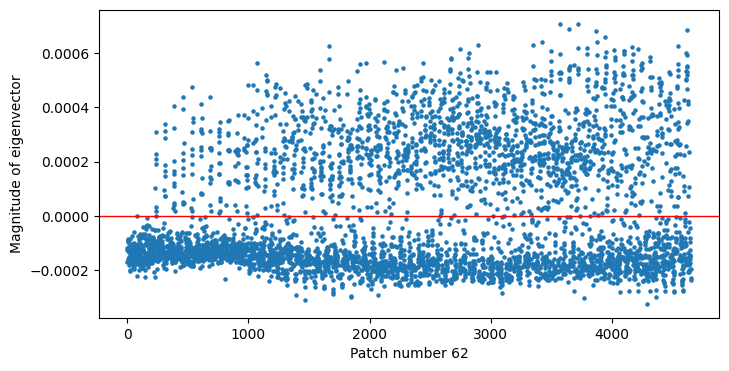

In [12]:
"""
"""
cls_attn = attentions.mean(1).squeeze()[0,1:].reshape(w_featmap, h_featmap)
num_eig = 5 # 사용할 eigenvector 개수

x_ctxed = _x_ctxed.squeeze()[1:, :] # N D
x_ctxed = F.normalize(x_ctxed,p=2)
x_ctxed_aff = x_ctxed @ x_ctxed.transpose(1,0) # N N
affinity_mat = x_ctxed_aff.clone()
attn = x_ctxed_aff.sum(dim=-1) # N

attn_norm_min = attn.min()
if attn_norm_min < 0:
    attn = attn - attn_norm_min + 1e-10
# attn /= attn.squeeze().sum()
attn = attn.reshape(w_featmap, h_featmap)
# attn = attentions.mean(1).squeeze()[0, 1:].squeeze().reshape(w_featmap, h_featmap) # num_patch num_patch
# attn_raw = attn.clone()
# attn = nn.functional.interpolate(attn.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode='nearest')[0].squeeze().numpy()
# fname = 'attn_map.png'
# plt.imsave(fname=fname, arr=attn, format='png')
"""
"""
def ncut(feats, patch_num, tau = 0.2, eps=1e-5, no_binary_graph=False, flip=False, force_flip=False):
     # cls_token = feats[0,0:1,:].cpu().numpy() 
    A = feats.cpu().numpy() # attention map, [196, 196]
    N = A.shape[0]
    # A = A > tau # [196 196]
    # A = np.where(A.astype(float) == 0, eps, A) # 0->epsilon, else same
    A = np.where(A.astype(float) <= tau, eps, A) # 0->epsilon, else same
    d_i = np.sum(A, axis=1) # [196 1] -> [196]
    D = np.diag(d_i) # [196 196] to diagonal, ex. [a b c] -> [a 0 0] [0 b 0] [0 0 c]
    
    laplacian = D - A
    # laplacian = identity(N).toarray() - (inv(D) @ A)
    # Print second and third smallest eigenvector 
    eigenvalues, eigenvectors = eigh(laplacian, D, subset_by_index=[1,num_eig])
    print(eigenvectors.shape)

    # Using average point to compute bipartition 
    second_smallest_vec = eigenvectors[:, 0] # [M]
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    #avg = 0
    # print(f'Average is {avg}')
    bipartition = second_smallest_vec > avg # [M]
    bipartition = bipartition.reshape(*patch_num).astype(float) # [14, 14]
    
    return bipartition, second_smallest_vec, eigenvectors

mask, eigenvec, full_eigen = ncut(affinity_mat, (w_featmap, h_featmap), tau = 0.2)
# mask = torch.tensor(mask)
# mask = mask.flatten()

eigenvec_sorted = np.sort(eigenvec)
x_val = list(range(int(eigenvec.shape[0])))
plt.figure(figsize=[8,4])
plt.scatter(x_val, eigenvec, s=5)
plt.axhline(y=0, color='r', linewidth=1)
plt.ylabel('Magnitude of eigenvector')

plt.xlabel(f'Patch number {int(attn.shape[0])}')
plt.show()
# 나오는 figure는 eivenvector의 각 element의 값 (=patch의 개수)

In [15]:
x_ctxed.shape

torch.Size([4650, 384])

In [14]:
attentions.shape

torch.Size([1, 6, 4651, 4651])

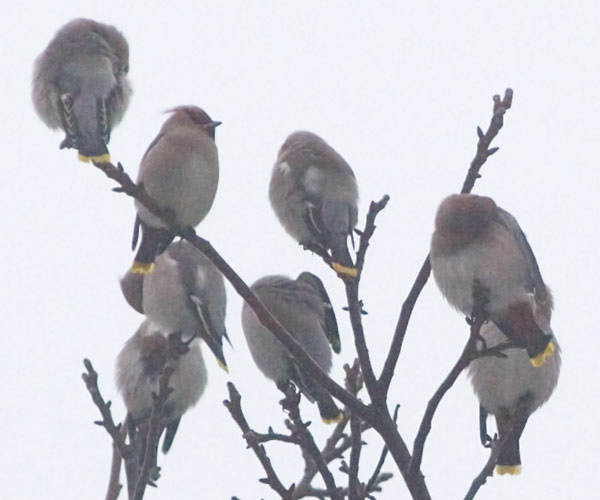

In [128]:
orig_img

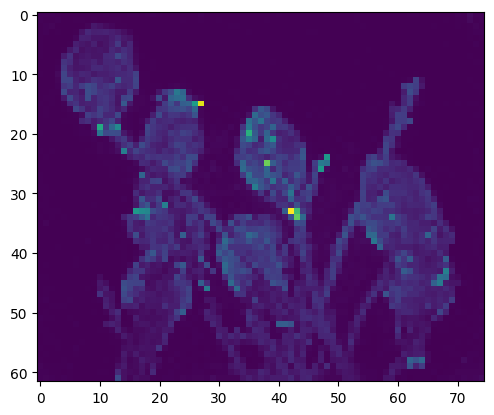

In [129]:
plt.imshow(cls_attn.cpu())

In [34]:
def visualization(orig_img, cls_attn, attn, clustered):
    cls_attn = nn.functional.interpolate(cls_attn.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
    th_attn = nn.functional.interpolate(attn.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
    clustered = nn.functional.interpolate(clustered.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
    print(cls_attn.shape, th_attn.shape, clustered.shape)
    
    # # orig_img = orig_img.resize((224,224))
    np_img = np.array(orig_img)
    #np_img = np_img.astype(np.float32)
    fname = root + 'img.png'
    plt.imsave(fname=fname, arr=np_img, format='png')
    #read_img = cv2.imread(args.image_path)
    #original_image = cv2.cvtColor(read_img, cv2.COLOR_BGR2RGB)
    #original_image = original_image[0:w, 0:h]

    th_attn_np = np.array(th_attn)
    fname = root + 'attn.png'
    plt.imsave(fname=fname, arr=th_attn_np, format='png')
    th_attn_rgb = cv2.imread(fname)
    attention_map = cv2.cvtColor(th_attn_rgb, cv2.COLOR_BGR2RGB)
    
    cls_attn = np.array(cls_attn)
    fname = root + 'cls_attn.png'
    plt.imsave(fname=fname, arr=cls_attn, format='png')
    cls_attn = cv2.imread(fname)
    cls_attn = cv2.cvtColor(cls_attn, cv2.COLOR_BGR2RGB)
    
    partitinoed = np.array(clustered)
    fname = root + 'partitinoed.png'
    plt.imsave(fname=fname, arr=partitinoed, format='png')
    partitinoed = cv2.imread(fname)
    partitinoed = cv2.cvtColor(partitinoed, cv2.COLOR_BGR2RGB)
    #print(np_img.shape, attention_map.shape)
    #print(np_img)
    #print(attention_map)
    attn_layered = cv2.addWeighted(np_img, 0.6, attention_map, 0.2,0)
    cls_attn_layered = cv2.addWeighted(np_img, 0.6, cls_attn, 0.2,0)
    partition_layered = cv2.addWeighted(np_img, 0.6, partitinoed, 0.2,0)
    # plt.imshow(added_image)
    
    img_list = [orig_img, cls_attn, cls_attn_layered, partition_layered, th_attn, attn_layered]
    title_list = ['Image', 'Cls attn', 'Cls attn overlayed', 'Partitioned', 'Similarity based', 'Sim overlayed']
    multi_plot(img_list, title_list, 3, is_short=True)

In [99]:
k = 10 # kmeans 개수
model = KMeans(n_clusters=k, random_state=5)
model.fit(full_eigen)
result = model.fit_predict(full_eigen)
scaled = result / k
clustered = torch.tensor(scaled).reshape(w_featmap, h_featmap)

torch.Size([400, 640])


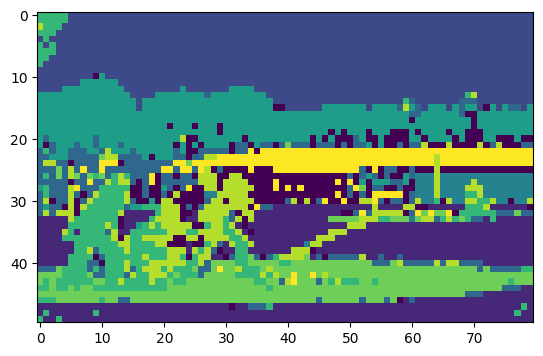

In [100]:
plt.imshow(clustered)
plot_clustered = nn.functional.interpolate(clustered.unsqueeze(0).unsqueeze(0), scale_factor=args.patch_size, mode="nearest")[0][0]
print(plot_clustered.shape)
plt.imsave(fname='/home/shhan/oicr/outputs/tests/'+args.image_path.split('/')[-1][:-4]+'_'+str(k)+'.png', arr=plot_clustered, format='png')

In [46]:
visualization(orig_img, cls_attn, attn, clustered)

torch.Size([344, 640]) torch.Size([344, 640]) torch.Size([344, 640])


FileNotFoundError: [Errno 2] No such file or directory: 'vis_examples/img.png'

In [43]:
def NormalizeTensor(data):
    return (data - torch.min(data)) / (torch.max(data) - torch.min(data))


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

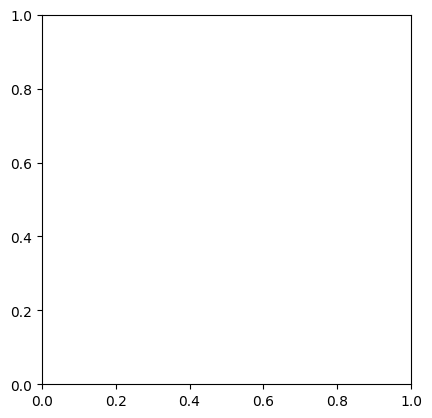

In [44]:
plt.imshow(0.7*NormalizeTensor(cls_attn)+0.3*NormalizeTensor(attn))

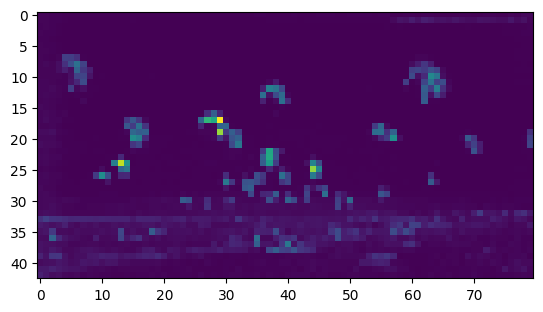

In [48]:
plt.imshow(cls_attn.cpu())

In [45]:
partitinoed = cv2.imread(root+'partitinoed.png')
partitinoed = cv2.cvtColor(partitinoed, cv2.COLOR_BGR2RGB)
plt.imshow(partitinoed)

[ WARN:0@24751.787] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('vis_examples/partitinoed.png'): can't open/read file: check file path/integrity


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [110]:
def bwlabel(clustered, conn): # clustered (torch)
    if (conn != 4) and (conn !=8):
        print("Incorrect connectivity. Can only be 4 or 8")
        return -1
    
    clustered = np.array(clustered) # torch -> numpy
    [x,y] = clustered.shape 
    clusters = np.unique(clustered) # the total types of clusters

    tot_labels = []
    for c in clusters:
        mask = np.array(clustered==c, dtype=bool) # True or false
        mask = mask.astype(np.int32) # 0 or 1

        # expand data not to crash when searching
        data = np.pad(mask, ((1,0),(1,1)), 'constant',constant_values=0) # pad on (top, down), (left, right)

        [x,y] = data.shape
        labels = np.zeros(data.shape)
        nextlabel = 0
        linked = {}

        for i in range(1,x): # each row
            for j in range(1,y-1): # each column
                if data[i,j] !=0: # not background
                    if (conn == 8):
                        neighborsearch = np.array([data[i-1,j-1], data[i-1,j], data[i-1,j+1], data[i,j-1]])
                    elif (conn == 4):
                        neighborsearch = np.array([data[i-1,j], data[i,j-1]])
                    # search for neighbors with binary value 1 
                    n = np.where(neighborsearch==1)[0]

                    # if no neighbor is already labeled, assign new label
                    if len(n)==0:
                        linked[nextlabel] = np.array([nextlabel])
                        labels[i,j] = nextlabel
                        nextlabel = nextlabel+1

                    # if neighbors is labeled, pick the lowest label and store the connected labels in linked
                    else:
                        if (conn == 8):
                            neighborsearch_label = np.array([labels[i-1,j-1], labels[i-1,j], labels[i-1,j+1], labels[i,j-1]])
                        elif (conn == 4):
                            neighborsearch_label = np.array([labels[i-1,j], labels[i,j-1]])

                        L = neighborsearch_label[n]
                        labels[i,j] = np.min(L)

                        for k in range(len(L)):
                            label = L[k]
                            linked[label] = np.unique(np.append(linked[label], L))

        labels = labels[1:,1:-2] # remove the previous expansion of the image

        ## for each link, look through the other links and look for common labels
        # if common labels exist they are linked, replace both link w/ the union of the two.
        # repeat until there is no change in the links.
        
        change2 = 1
        while change2 == 1:
            change = 0
            for i in range(len(linked)):
                for j in range(len(linked)):
                    if i!=j:
                        if (np.sum(np.isin(linked[i],linked[j])) >0) and \
                            (np.sum(np.isin(linked[i],linked[j])) != len(linked[i])):
                            change = 1
                            linked[i] = np.union1d(linked[i], linked[j])
                            linked[j] = linked[i]


            if change == 0:
                change2 = 0
                
        # removing redundant links
        #linked = np.unique([str(i) for i in linked]) 
        #linked = [int(i) for i in linked]

        K = len(linked)
        templabels = labels
        labels = np.zeros(labels.shape)
        # label linked labels with a single label
        for k in range(K):
            for l in range(len(linked[k])):
                labels[templabels == linked[k][l]] = k

        tot_labels.append(labels)

    return tot_labels

tot_labels = bwlabel(clustered, 4)

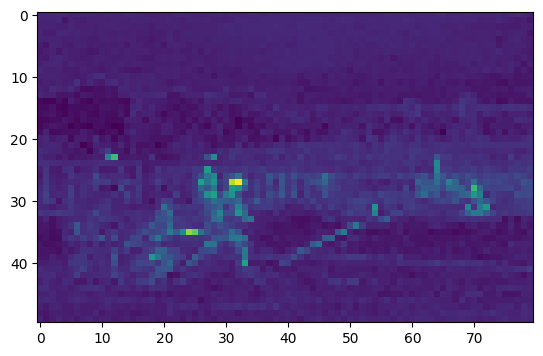

total_bboxes:  1


In [112]:
import matplotlib.patches as patches

mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)
mask_attn = mask_attn.cpu()
fig, ax = plt.subplots()
#ax.imshow(mask*255)
ax.imshow(mask_attn.cpu())
colors = ['b','g','r','darkorange','hotpink','sienna','black','darkviolet','pink','wheat']
bboxes = []
tot_bboxes = 0
for c in range(k):
    bbox = np.unique(tot_labels[c])

    for i in bbox[1:]:
        idx = np.where(tot_labels[c]==i)
        
        if np.mean([mask_attn[idx[0][i],idx[1][i]] for i in range(len(idx[0]))]) < mask_attn.mean():
            continue
        x1 = np.min(idx[0]); x2 = np.max(idx[0])
        y1 = np.min(idx[1]); y2 = np.max(idx[1])
        if (((x2-x1) > 1) or ((y2-y1) > 1)) and not (y1==0 and x1==0) :
            rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor=colors[c], facecolor='none')
            #img = cv2.rectangle(img, (x1,y1), (x2,y2), (0,0,255))
            bboxes.append([x1, y1, x2, y2])
            ax.add_patch(rect)
            tot_bboxes +=1

plt.show()
print("total_bboxes: ", tot_bboxes)

In [73]:
mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)
def get_bbox(tot_labels, c):
    bboxes = []
    tot_bboxes = 0
    for c in range(k):
        bbox = np.unique(tot_labels[c])

        for i in bbox[1:]:
            idx = np.where(tot_labels[c]==i)
        
            if np.mean([mask_attn[idx[0][i],idx[1][i]] for i in range(len(idx[0]))]) < 1e-5:
                continue
            x1 = np.min(idx[0]); x2 = np.max(idx[0])
            y1 = np.min(idx[1]); y2 = np.max(idx[1])

            if (((x2-x1) > 1) or ((y2-y1) > 1)) and not (y1==0 and x1==0):
                bboxes.append([x1, y1, x2, y2])
                tot_bboxes +=1

    return bboxes

In [74]:
#from torchvision.ops import complete_box_iou_loss as box_iou
from torchvision.ops.boxes import box_iou
def nms(bboxes: torch.Tensor, scores: torch.Tensor, iou_threshold: float):
    order = torch.argsort(-scores)
    indices = torch.arange(bboxes.shape[0])
    keep = torch.ones_like(indices, dtype=torch.bool)
    for i in indices:
        if keep[i]:
            bbox = bboxes[order[i]]
            iou = box_iou(bbox[None,...],(bboxes[order[i + 1:]]) * keep[i + 1:][...,None])
            overlapped = torch.nonzero(iou > iou_threshold)
            keep[overlapped + i + 1] = 0
    return order[keep]

In [113]:
def wasserstein_nms_op(dets_wl, scores, order, dets_sorted, iou_threshold, multi_label):
    pass

def wasserstein_nms(dets, scores, iou_threshold, labels=None):
    """Performs non-maximum suppression (NMS) on the rotated boxes according to
    their intersection-over-union (IoU).

    Rotated NMS iteratively removes lower scoring rotated boxes which have an
    IoU greater than iou_threshold with another (higher scoring) rotated box.

    Args:
        boxes (Tensor):  Rotated boxes in shape (N, 5). They are expected to \
            be in (x_ctr, y_ctr, width, height, angle_radian) format.
        scores (Tensor): scores in shape (N, ).
        iou_threshold (float): IoU thresh for NMS.
        labels (Tensor): boxes's label in shape (N,).

    Returns:
        tuple: kept dets(boxes and scores) and indice, which is always the \
            same data type as the input.
    """
    if dets.shape[0] == 0:
        return dets, None
    multi_label = labels is not None
    if multi_label:
        dets_wl = torch.cat((dets, labels.unsqueeze(1)), 1)
    else:
        dets_wl = dets
    _, order = scores.sort(0, descending=True)
    dets_sorted = dets_wl.index_select(0, order)

    keep_inds = wasserstein_nms_op(dets_wl, scores, order, dets_sorted,
                                           iou_threshold, multi_label)
    dets = torch.cat((dets[keep_inds], scores[keep_inds].reshape(-1, 1)),
                     dim=1)
    return dets, keep_inds

In [114]:
tot_bboxes = np.empty((1,4))
mask_attn = mask_attn.cpu()
for k in [2,5,10]: # kmeans 개수
    model = KMeans(n_clusters=k, random_state=5)
    model.fit(full_eigen)
    result = model.fit_predict(full_eigen)
    scaled = result / k
    clustered = torch.tensor(scaled).reshape(w_featmap, h_featmap)  

    tot_labels = bwlabel(clustered, 8)

    for c in range(k):
        tot_bboxes = np.concatenate((tot_bboxes, get_bbox(tot_labels, c)),axis=0)

tot_bboxes = tot_bboxes[1:] # get rid of empty bbox

In [115]:
tot_bboxes

array([[10.,  0., 49., 78.],
       [10.,  0., 49., 78.],
       [25., 65., 25., 74.],
       ...,
       [40., 14., 42., 15.],
       [41., 36., 42., 38.],
       [29., 54., 30., 58.]])

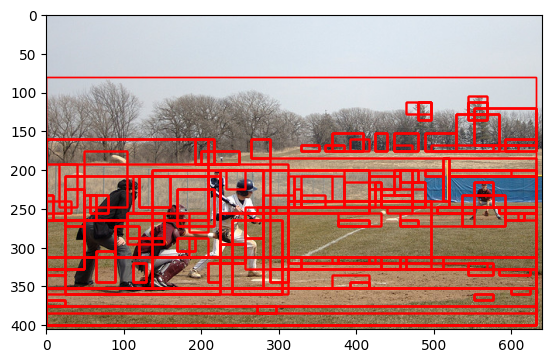

In [116]:
## mask attention
fig, ax = plt.subplots()
ax.imshow(orig_img)

mask_attn = mask_attn.cpu()

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
# max값 써보기 
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)

for i in range(len(tot_bboxes)):
    [x1, y1, x2, y2] = tot_bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()
fig.savefig('/home/shhan/oicr/outputs/tests/'+args.image_path.split('/')[-1][:-4]+'_bboxes.png')

TypeError: iteration over a 0-d array

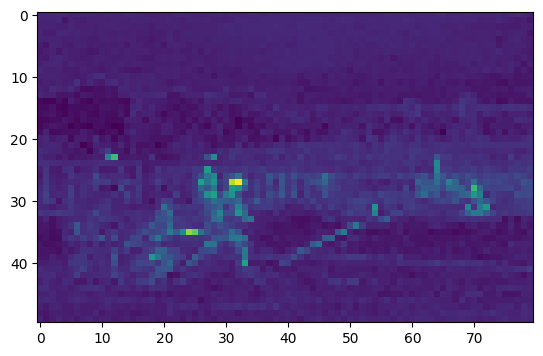

In [113]:
## mask attention
fig, ax = plt.subplots()
ax.imshow(mask_attn.cpu())

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
# max값 써보기 
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
idx = np.where(np.array(cls_scores) > 20)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.3)#, conf_threshold=0.05)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [130]:
cls_scores.mean()

23.098358924350432

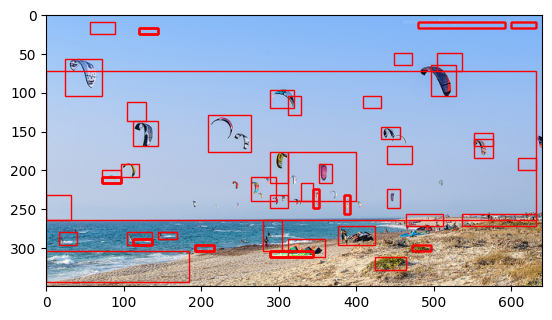

In [80]:
fig, ax = plt.subplots()
ax.imshow(orig_img)

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(mask_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
idx = np.where(np.array(cls_scores) > 15)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.06)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

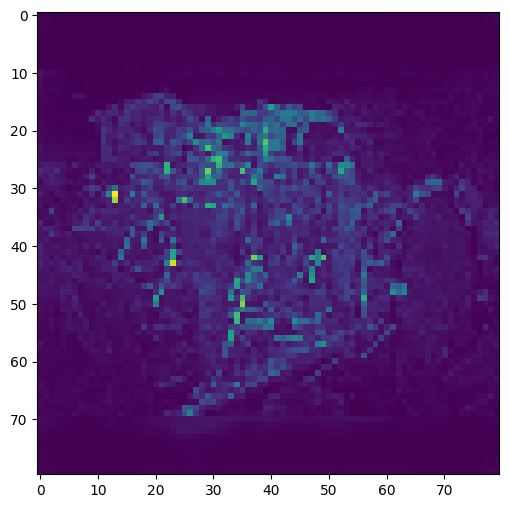

In [132]:
## cls attention
fig, ax = plt.subplots()
ax.imshow(cls_attn)

cls_scores = np.array([np.mean(np.array(cls_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
# max값 써보기 
tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
idx = np.where(np.array(cls_scores) > 0.1)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.3)#, conf_threshold=0.05)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1, x1), (y2-y1+1), (x2-x1+1), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

In [133]:
cls_scores.mean()

0.023243565857785965

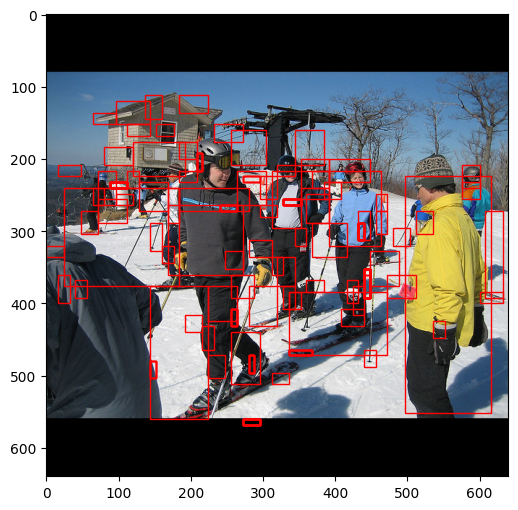

In [134]:
fig, ax = plt.subplots()
ax.imshow(orig_img)

tot_bboxes = np.array(tot_bboxes, dtype=np.int32)
cls_scores = np.array([np.mean(np.array(cls_attn[bbox[0]:bbox[2]+1,bbox[1]:bbox[3]+1]))*100 for bbox in tot_bboxes])
idx = np.where(np.array(cls_scores) > 0.01)[0]
bboxes = tot_bboxes[idx]
scores = cls_scores[idx]
selected = nms(torch.Tensor(bboxes), torch.Tensor(scores), iou_threshold=0.06)
for i in selected:
    [x1, y1, x2, y2] = bboxes[i]
    rect = patches.Rectangle((y1*8, x1*8), (y2-y1+1)*8, (x2-x1+1)*8, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

plt.show()

761


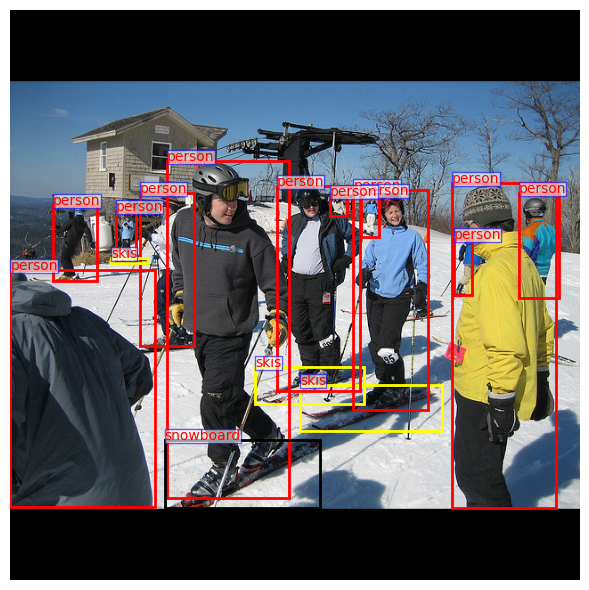

In [135]:
get_gt(args.image_path, orig_img, pad)

In [ ]:
import pickle 
transform = pth_transforms.Compose([
        pth_transforms.ToTensor(),
        pth_transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

proposals = {}
for i in range(len(img_path)):
    im = img_path[i]
    with open(im, 'rb') as f:
        orig_img = Image.open(f)
        orig_img = orig_img.convert('RGB')
    
    img = transform(orig_img)
    w, h = img.shape[1] - img.shape[1] % args.patch_size, img.shape[2] - img.shape[2] % args.patch_size
    img = img[:, :w, :h].unsqueeze(0)
    w_featmap = img.shape[-2] // args.patch_size
    h_featmap = img.shape[-1] // args.patch_size

    attentions, _x_ctxed, _x_final = model.get_last_selfattention(img.to(device)) # 1 head 1+tokens 1+tokens

    cls_attn = attentions.mean(1).squeeze()[0,1:].reshape(w_featmap, h_featmap)
    num_eig = 5 # 사용할 eigenvector 개수

    x_ctxed = _x_ctxed.squeeze()[1:, :] # N D
    x_ctxed = F.normalize(x_ctxed,p=2)
    x_ctxed_aff = x_ctxed @ x_ctxed.transpose(1,0) # N N
    affinity_mat = x_ctxed_aff.clone()
    attn = x_ctxed_aff.sum(dim=-1) # N

    attn_norm_min = attn.min()
    if attn_norm_min < 0:
        attn = attn - attn_norm_min + 1e-10
    # attn /= attn.squeeze().sum()
    attn = attn.reshape(w_featmap, h_featmap)

    mask, eigenvec, full_eigen = ncut(affinity_mat, (w_featmap, h_featmap), tau = 0.2)
    eigenvec_sorted = np.sort(eigenvec)
    x_val = list(range(int(eigenvec.shape[0])))

    mask_attn = 0.8*NormalizeTensor(cls_attn)+0.2*NormalizeTensor(attn)
    tot_bboxes = np.empty((1,4))
    
    for k in [2,5,10]: # kmeans 개수
        kmeans = KMeans(n_clusters=k, random_state=5)
        kmeans.fit(full_eigen)
        result = kmeans.fit_predict(full_eigen)
        scaled = result / k
        clustered = torch.tensor(scaled).reshape(w_featmap, h_featmap)  
        
        tot_labels = bwlabel(clustered, 4)

        for c in range(k):
            if len(get_bbox(tot_labels, c, mask_attn)) == 0:
                continue
            tot_bboxes = np.concatenate((tot_bboxes, get_bbox(tot_labels, c, mask_attn)),axis=0)

    tot_bboxes = tot_bboxes[1:] # get rid of empty bbox
    proposals[ids[i]] = tot_bboxes

    if i % 10 == 0:
        with open('../data/coco_train2017_proposals.pkl', 'wb') as f:
            pickle.dump(proposals, f, pickle.HIGHEST_PROTOCOL)
        print("../data/coco_train2017_proposals.pkl saved")